# $\mu$ MAG Standrad Problem \#4

We want to model the dynamics ot the Landau-Lifshitz-Gilbert (LLG) equation in as film (as depicted below):
$$
\frac{d \mathbf{M}}{dt} = - \gamma_0 (\mathbf{M} \times \mathbf{H_{\text{eff}}}) + \frac{\alpha}{M_s} (\mathbf{M} \times \frac{d \mathbf{M}}{dt})~,
$$
with the following parameters: $\alpha = 0.02, \gamma_0 = 2.211 \times 10^5$ [m/(As)].

Further, permalloy is chosen as material with: $A = 1.3 \times 10^{-11}$ [J/m], $M_s = 8.0 \times 10^5$ [A/m], and $K = 0.0$.

More details can be found on the official [website](https://www.ctcms.nist.gov/~rdm/std4/spec4.html).

![std_prob_4](../images/std_problem_4.png)

## MagTense to solve micromagnetic setup

In a first step, we want to use [MagTense](https://github.com/cmt-dtu-energy/MagTense) to solve this.

Here, we solve the LLG in a slightly different form:
$$
\frac{d \mathbf{M}}{dt} = - \gamma_0' (\mathbf{M} \times \mathbf{H_{\text{eff}}}) + \frac{\lambda}{M_s} \mathbf{M} \times (\mathbf{M} \times \mathbf{H_{\text{eff}}})~,
$$
where $\gamma_0' = \gamma_0 / (1 + \alpha^2)$ and $\lambda = \gamma_0 \alpha / (1 + \alpha^2)$.

In [1]:
import numpy as np
from magtense.micromag import MicromagProblem
from magtense.utils import plot_M_thin_film

from koopmag.utils import plot_dynamics

In [2]:
# GPU usage
cuda = True

# Problem parameters
grid_L = [500e-9, 125e-9, 3e-9]
Ms = 8e5
A0 = 1.3e-11
K0 = 0.0
alpha = 0.02
gam_0 = 2.211e5

lam = (gam_0 * alpha) / (1 + alpha**2)
gam_0_p = gam_0 / (1 + alpha**2)
# Speeding up convegene for s-state
gam_0_p_init = 0

# Inital magnetization configuration
# https://github.com/cmt-dtu-energy/MagTense/blob/v1.2/python/src/magtense/micromag.py#L156
# Initialize [1/srqt(3), 1/srqt(3), 1/srqt(3)] everywhere
# Unit norm, which is preserved in micromagnetism
m0 = 1 / np.sqrt(3)

# Other constants
mu0 = 4 * np.pi * 1e-7 # [H/m]
res = [36, 9, 1] # Number of cells in x, y, z directions

problem_s_state = MicromagProblem(
    res=res,
    grid_L=grid_L,
    m0=m0,
    alpha=lam,
    gamma=gam_0_p_init,
    cuda=cuda,
)

### Get initial state is an equilibrium s-state

![s-state](../images/s_state.gif)

Apply and slowly reduce a saturating external field $\mathbf{H_{\text{ext}}}$ along the [1,1,1] direction to zero. 

 Initializing matrices
 Copying to CUDA
 Initializing solution
 Running solution
 Time:     4.52 ns, i.e. step   10/ 200
 Time:     9.55 ns, i.e. step   20/ 200
 Time:    14.57 ns, i.e. step   30/ 200
 Time:    19.60 ns, i.e. step   40/ 200
 Time:    24.62 ns, i.e. step   50/ 200
 Time:    29.65 ns, i.e. step   60/ 200
 Time:    34.67 ns, i.e. step   70/ 200
 Time:    39.70 ns, i.e. step   80/ 200
 Time:    44.72 ns, i.e. step   90/ 200
 Time:    49.75 ns, i.e. step  100/ 200
 Time:    54.77 ns, i.e. step  110/ 200
 Time:    59.80 ns, i.e. step  120/ 200
 Time:    64.82 ns, i.e. step  130/ 200
 Time:    69.85 ns, i.e. step  140/ 200
 Time:    74.87 ns, i.e. step  150/ 200
 Time:    79.90 ns, i.e. step  160/ 200
 Time:    84.92 ns, i.e. step  170/ 200
 Time:    89.95 ns, i.e. step  180/ 200
 Time:    94.97 ns, i.e. step  190/ 200
 Time:   100.00 ns, i.e. step  200/ 200


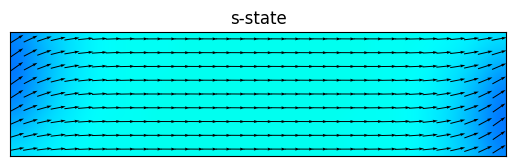

In [3]:
h_ext = np.array([1, 1, 1]) / mu0

# External field applied in every time step
def h_ext_fct(t) -> np.ndarray:
    return np.expand_dims(np.where(t < 1e-09, 1e-09 - t, 0), axis=1) * h_ext

# Run micromagnetic simulation
# https://github.com/cmt-dtu-energy/MagTense/blob/v1.2/python/src/magtense/micromag.py#L214
_, M_out, _, _, _, _, _ = problem_s_state.run_simulation(
    t_end=100e-9,
    nt=200,
    fct_h_ext=h_ext_fct,
    nt_h_ext=2000,
)
s_state = np.squeeze(M_out[-1], axis=1)
plot_M_thin_film(s_state, res, "s-state")

### Apply external magnetic field and plot dynamics

Two switching events will be calculated using fields applied in the x-y plane of different magnitude and direction.

- Field 1:  $\mu_0 H_x=-24.6$ mT, $\mu_0 H_y = 4.3$ mT, $\mu_0 H_z = 0.0$ mT  which is a field approximately 25 mT, directed 170 degrees counterclockwise from the positive x axis.
- Field 2:  $\mu_0 H_x=-35.5$ mT, $\mu_0 H_y =-6.3$ mT, $\mu_0 H_z = 0.0$ mT which is a field approximately 36 mT, directed 190 degrees counterclockwise from the positive x axis.

Each field will be applied instantaneously at $t=0$ to the equilibrium s-state .

In [4]:
# Two applied external fields of std problem 4
h_ext_nist_1 = np.array([-24.6e-3, 4.3e-3, 0])
h_ext_nist_2 = np.array([-35.5e-3, -6.3e-3, 0])

def h_ext_1_fct(t) -> np.ndarray:
    return np.expand_dims(t > -1, axis=1) * (h_ext_nist_1 / mu0)

def h_ext_2_fct(t) -> np.ndarray:
    return np.expand_dims(t > -1, axis=1) * (h_ext_nist_2 / mu0)

In [5]:
### Time-dependent solver
problem_dym = MicromagProblem(
    res=res,
    grid_L=grid_L,
    m0=s_state,
    alpha=lam,
    gamma=gam_0_p,
    cuda=cuda,
)
t_dym, M_dym, _, _, _, _, _ = problem_dym.run_simulation(1e-9, 200, h_ext_1_fct, 2000)

 Initializing matrices
 Copying to CUDA
 Initializing solution
 Running solution
 Time:     0.05 ns, i.e. step   10/ 200
 Time:     0.10 ns, i.e. step   20/ 200
 Time:     0.15 ns, i.e. step   30/ 200
 Time:     0.20 ns, i.e. step   40/ 200
 Time:     0.25 ns, i.e. step   50/ 200
 Time:     0.30 ns, i.e. step   60/ 200
 Time:     0.35 ns, i.e. step   70/ 200
 Time:     0.40 ns, i.e. step   80/ 200
 Time:     0.45 ns, i.e. step   90/ 200
 Time:     0.50 ns, i.e. step  100/ 200
 Time:     0.55 ns, i.e. step  110/ 200
 Time:     0.60 ns, i.e. step  120/ 200
 Time:     0.65 ns, i.e. step  130/ 200
 Time:     0.70 ns, i.e. step  140/ 200
 Time:     0.75 ns, i.e. step  150/ 200
 Time:     0.80 ns, i.e. step  160/ 200
 Time:     0.85 ns, i.e. step  170/ 200
 Time:     0.90 ns, i.e. step  180/ 200
 Time:     0.95 ns, i.e. step  190/ 200
 Time:     1.00 ns, i.e. step  200/ 200


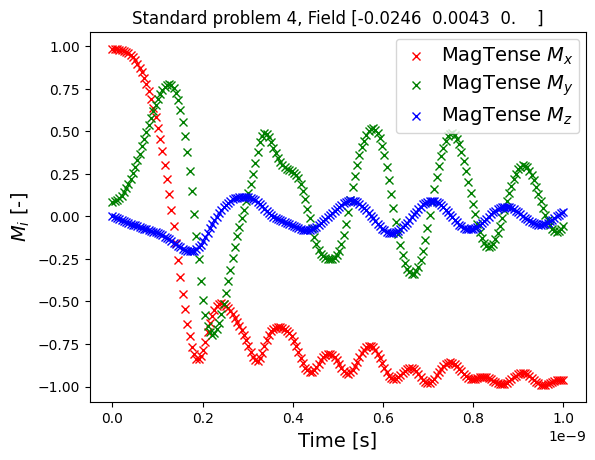

In [6]:
plot_dynamics(t_dym, M_dym, field=h_ext_nist_1)

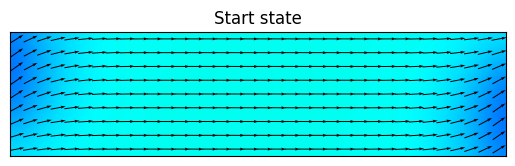

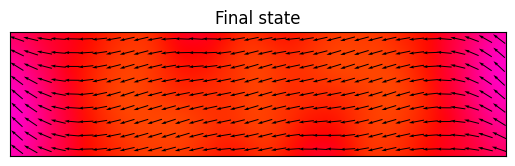

In [7]:
plot_M_thin_film(M_dym[0], res, "Start state")
plot_M_thin_film(M_dym[-1], res, "Final state")